In [1]:
# Colab cell 1/12 — install libs (safe to re-run)
!pip install -q openpyxl xgboost

# Standard imports
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, RandomizedSearchCV, cross_validate
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.multioutput import MultiOutputRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import joblib
import json
import warnings
warnings.filterwarnings("ignore")
RND = 42
np.random.seed(RND)


In [2]:
%cd /content/drive/MyDrive/Nutrition_prediction

/content/drive/MyDrive/Nutrition_prediction


In [5]:


# Option B: use Google Drive (uncomment and run if file is in Drive)
from google.colab import drive

fname = '/content/drive/MyDrive/Nutrition_prediction/Nutrition Ai Dataset.xlsx'
print("Using file:", fname)


Using file: /content/drive/MyDrive/Nutrition_prediction/Nutrition Ai Dataset.xlsx


In [6]:
# Colab cell 3/12 — load your Excel into a DataFrame
# If you used upload in previous cell, `fname` is defined; otherwise set fname path manually.

try:
    df = pd.read_excel(fname)   # default: first sheet
except Exception as e:
    print("Error reading Excel file:", e)
    # try specifying engine
    df = pd.read_excel(fname, engine='openpyxl')

# Normalize column names
df.columns = [str(c).strip() for c in df.columns]
print("Shape:", df.shape)
print("Columns:", df.columns.tolist())
display(df.head(10))


Shape: (110, 15)
Columns: ['Name', 'Weight', 'F1', 'F2', 'F3', 'F4', 'F5', 'F6', 'F7', 'F8', 'NIR', 'Proteins', 'Carbohydrates', 'Fats', 'Calories']


,Name,Weight,F1,F2,F3,F4,F5,F6,F7,F8,NIR,Proteins,Carbohydrates,Fats,Calories
0,Tata Coffee Grand Classic,8.56,2.0,7.0,8.0,10.0,21.0,28.0,29.0,20.0,6.0,0.0,0.8,0.0,3.6
1,NaN,NaN,2.0,8.0,9.0,11.0,23.0,28.0,30.0,19.0,4.0,0.0,0.8,0.0,3.6
2,NaN,NaN,1.0,7.0,8.0,9.0,20.0,26.0,28.0,19.0,6.0,0.0,0.8,0.0,3.6
3,NaN,NaN,1.0,7.0,8.0,9.0,19.0,26.0,27.0,18.0,6.0,0.0,0.8,0.0,3.6
4,NaN,NaN,1.0,7.0,7.0,9.0,19.0,26.0,27.0,18.0,6.0,0.0,0.8,0.0,3.6
5,NaN,NaN,1.0,7.0,7.0,9.0,18.0,25.0,26.0,17.0,4.0,0.0,0.8,0.0,3.6
6,NaN,NaN,1.0,6.0,7.0,9.0,18.0,25.0,27.0,18.0,6.0,0.0,0.8,0.0,3.6
7,NaN,NaN,1.0,6.0,6.0,8.0,16.0,22.0,23.0,15.0,4.0,0.0,0.8,0.0,3.6
8,NaN,NaN,1.0,7.0,7.0,9.0,19.0,25.0,27.0,18.0,4.0,0.0,0.8,0.0,3.6
9,NaN,NaN,1.0,6.0,7.0,8.0,18.0,23.0,25.0,16.0,4.0,0.0,0.8,0.0,3.6


Meta columns (kept but not used for modeling): ['Name', 'Weight']

Missing values per column:
 Weight           101
Name             100
F1                 9
F2                 9
F3                 9
F4                 9
F5                 9
F6                 9
F7                 9
F8                 9
NIR                9
Proteins           9
Carbohydrates      9
Fats               9
Calories           9
dtype: int64

Data types:
 Name              object
Weight           float64
F1               float64
F2               float64
F3               float64
F4               float64
F5               float64
F6               float64
F7               float64
F8               float64
NIR              float64
Proteins         float64
Carbohydrates    float64
Fats             float64
Calories         float64
dtype: object


,count,mean,std,min,25%,50%,75%,max
F1,101.0,8.386139,11.474293,1.00,3.0000,5.0000,7.0000,50.00
F2,101.0,53.990099,98.016580,6.00,11.0000,16.0000,40.0000,414.00
F3,101.0,58.910891,102.070280,6.00,12.0000,20.0000,49.0000,433.00
F4,101.0,65.881188,103.381457,8.00,14.0000,33.0000,57.0000,443.00
F5,101.0,112.693069,140.925494,16.00,36.0000,72.0000,113.0000,629.00
F6,101.0,119.623762,126.303274,22.00,50.0000,90.0000,127.0000,575.00
F7,101.0,103.148515,97.433709,23.00,49.0000,79.0000,112.0000,458.00
F8,101.0,55.207921,44.909312,15.00,29.0000,45.0000,60.0000,216.00
NIR,101.0,15.950495,16.536854,4.00,6.0000,12.0000,16.0000,80.00
Proteins,101.0,0.100089,0.063170,0.00,0.0500,0.1226,0.1300,0.20


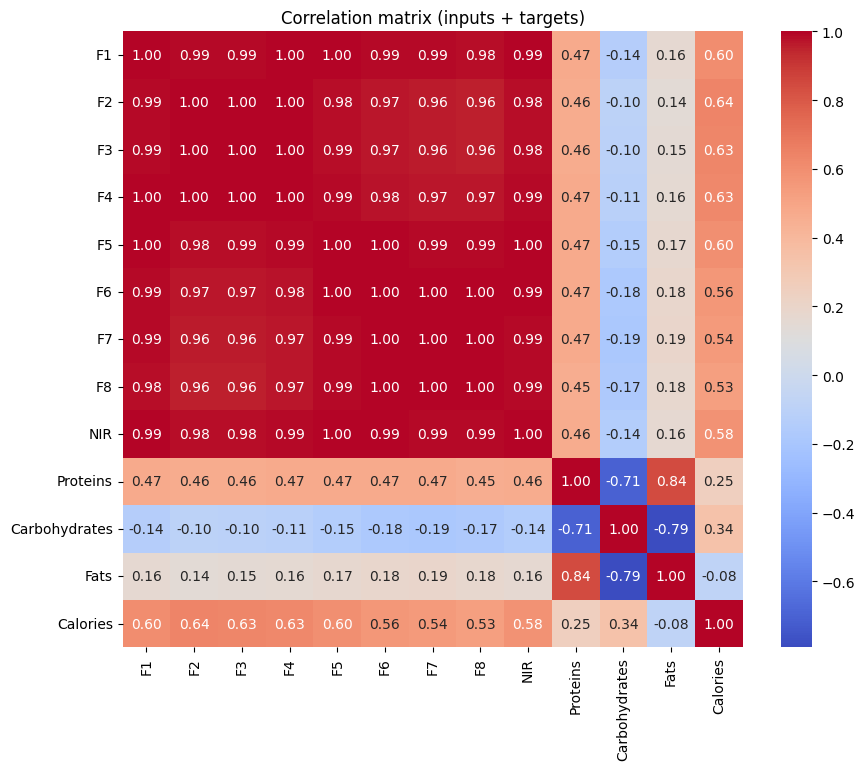


Top inputs correlated with Proteins:
 F6    0.474018
F5    0.473083
F7    0.472805
F4    0.472787
Name: Proteins, dtype: float64

Top inputs correlated with Carbohydrates:
 F7    0.186916
F6    0.177304
F8    0.172826
F5    0.147402
Name: Carbohydrates, dtype: float64

Top inputs correlated with Fats:
 F7    0.191769
F6    0.182225
F8    0.178333
F5    0.167911
Name: Fats, dtype: float64

Top inputs correlated with Calories:
 F2    0.640652
F3    0.633292
F4    0.628308
F1    0.603931
Name: Calories, dtype: float64


In [7]:
# Colab cell 4/12 — EDA summary
pd.set_option('display.max_columns', 200)

# Define expected input/target columns (adjust if names differ)
input_cols = [f"F{i}" for i in range(1,9)] + ["NIR"]     # F1..F8 + NIR
target_cols = ["Proteins", "Carbohydrates", "Fats", "Calories"]
meta_cols = [c for c in df.columns if c not in input_cols + target_cols]

print("Meta columns (kept but not used for modeling):", meta_cols)
print("\nMissing values per column:\n", df.isna().sum().sort_values(ascending=False).head(20))
print("\nData types:\n", df.dtypes)

# Convert expected numeric columns to numeric (coerce if strings)
for c in input_cols + target_cols:
    if c in df.columns:
        df[c] = pd.to_numeric(df[c], errors='coerce')

# Basic stats for numeric columns
display(df[input_cols + target_cols].describe().T)

# Correlation matrix (inputs + targets)
corr = df[input_cols + target_cols].corr()
plt.figure(figsize=(10,8))
sns.heatmap(corr, annot=True, fmt=".2f", cmap='coolwarm', square=False)
plt.title("Correlation matrix (inputs + targets)")
plt.show()

# Show top 4 correlated inputs for each target
for t in target_cols:
    if t in df.columns:
        corrs = corr[t].drop(t).loc[input_cols].abs().sort_values(ascending=False).head(4)
        print(f"\nTop inputs correlated with {t}:\n", corrs)


In [8]:
# Colab cell 5/12 — preprocessing decisions
# 1) Choose inputs and targets that actually exist in dataset
X_cols = [c for c in input_cols if c in df.columns]
y_cols = [c for c in target_cols if c in df.columns]
print("Using inputs:", X_cols)
print("Using targets:", y_cols)

# 2) Drop rows with missing values in inputs/targets (simple approach)
df_model = df[X_cols + y_cols].dropna().reset_index(drop=True)
print("After dropna rows:", df_model.shape)

# 3) Optionally: you can use imputation instead of dropna
# from sklearn.impute import SimpleImputer
# imp = SimpleImputer(strategy='median')
# df_model[X_cols] = imp.fit_transform(df_model[X_cols])

# 4) Prepare arrays
X = df_model[X_cols].values
y = df_model[y_cols].values

# 5) train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RND)
print("Train shape:", X_train.shape, y_train.shape, "Test shape:", X_test.shape, y_test.shape)


Using inputs: ['F1', 'F2', 'F3', 'F4', 'F5', 'F6', 'F7', 'F8', 'NIR']
Using targets: ['Proteins', 'Carbohydrates', 'Fats', 'Calories']
After dropna rows: (101, 13)
Train shape: (80, 9) (80, 4) Test shape: (21, 9) (21, 4)


In [9]:
# Colab cell 6/12 — models and eval helper

def evaluate_multioutput(y_true, y_pred, targets):
    res = []
    for i, tname in enumerate(targets):
        mse = mean_squared_error(y_true[:,i], y_pred[:,i])
        rmse = np.sqrt(mse)
        mae = mean_absolute_error(y_true[:,i], y_pred[:,i])
        r2 = r2_score(y_true[:,i], y_pred[:,i])
        res.append({"target": tname, "rmse": rmse, "mae": mae, "r2": r2})
    return pd.DataFrame(res)

# Models dictionary (we will build pipelines with scaling for those that benefit)
models = {}

# LinearRegression supports multioutput natively — include scaler
models['LinearRegression'] = Pipeline([('scaler', StandardScaler()), ('reg', LinearRegression())])

# RandomForest works with multioutput directly (no wrapper required); scaling not necessary but harmless
models['RandomForest'] = Pipeline([('scaler', StandardScaler()), ('reg', RandomForestRegressor(n_estimators=200, random_state=RND, n_jobs=-1))])

# GradientBoostingRegressor doesn't natively multi-output in some sklearn versions — wrap via MultiOutputRegressor
gb = GradientBoostingRegressor(random_state=RND)
models['GradientBoosting_MultiOut'] = Pipeline([('scaler', StandardScaler()), ('reg', MultiOutputRegressor(gb))])

# XGBoost (wrap)
from xgboost import XGBRegressor
xgb = XGBRegressor(n_jobs=4, random_state=RND, verbosity=0)
models['XGBoost_MultiOut'] = Pipeline([('scaler', StandardScaler()), ('reg', MultiOutputRegressor(xgb))])

# MLPRegressor (multioutput supported)
models['MLP'] = Pipeline([('scaler', StandardScaler()), ('reg', MLPRegressor(hidden_layer_sizes=(128,64), max_iter=1000, random_state=RND))])

print("Models prepared:", list(models.keys()))


Models prepared: ['LinearRegression', 'RandomForest', 'GradientBoosting_MultiOut', 'XGBoost_MultiOut', 'MLP']


In [10]:
# Colab cell 7/12 — train & evaluate
results = []
fitted_models = {}

for name, pipe in models.items():
    print("Training:", name)
    pipe.fit(X_train, y_train)
    y_pred = pipe.predict(X_test)
    metrics_df = evaluate_multioutput(y_test, y_pred, y_cols)
    avg_rmse = metrics_df['rmse'].mean()
    results.append({
        "model": name,
        "avg_rmse": avg_rmse,
        "metrics": metrics_df
    })
    fitted_models[name] = pipe

# Build a neat summary table
summary_rows = []
for r in results:
    row = {"model": r["model"], "avg_rmse": r["avg_rmse"]}
    for _, rr in r["metrics"].iterrows():
        row[f"{rr['target']}_rmse"] = rr['rmse']
        row[f"{rr['target']}_mae"] = rr['mae']
        row[f"{rr['target']}_r2"] = rr['r2']
    summary_rows.append(row)

summary_df = pd.DataFrame(summary_rows).sort_values("avg_rmse")
display(summary_df.round(4))


Training: LinearRegression
Training: RandomForest
Training: GradientBoosting_MultiOut
Training: XGBoost_MultiOut
Training: MLP


,model,avg_rmse,Proteins_rmse,Proteins_mae,Proteins_r2,Carbohydrates_rmse,Carbohydrates_mae,Carbohydrates_r2,Fats_rmse,Fats_mae,Fats_r2,Calories_rmse,Calories_mae,Calories_r2
2,GradientBoosting_MultiOut,0.0684,0.0224,0.0114,0.8884,0.0357,0.0194,0.9390,0.0253,0.0109,0.8896,0.1903,0.1163,0.7810
1,RandomForest,0.0714,0.0199,0.0126,0.9119,0.0456,0.0306,0.9007,0.0297,0.0177,0.8479,0.1904,0.1290,0.7807
3,XGBoost_MultiOut,0.0753,0.0230,0.0099,0.8818,0.0327,0.0166,0.9488,0.0266,0.0121,0.8785,0.2190,0.1445,0.7098
0,LinearRegression,0.1158,0.0457,0.0387,0.5337,0.1151,0.1012,0.3668,0.0508,0.0434,0.5551,0.2515,0.2148,0.6173
4,MLP,0.1386,0.0494,0.0386,0.4542,0.1316,0.1140,0.1717,0.0708,0.0570,0.1362,0.3026,0.2758,0.4460


Best model: GradientBoosting_MultiOut


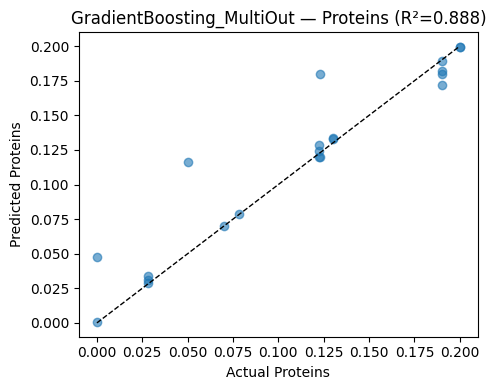

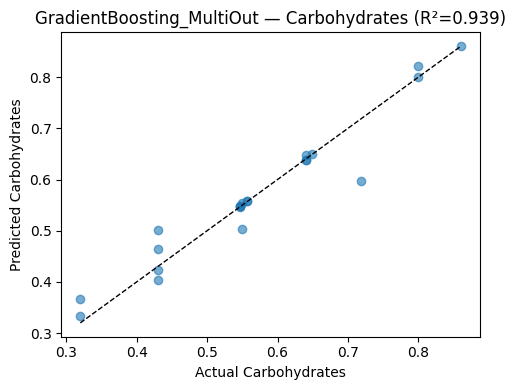

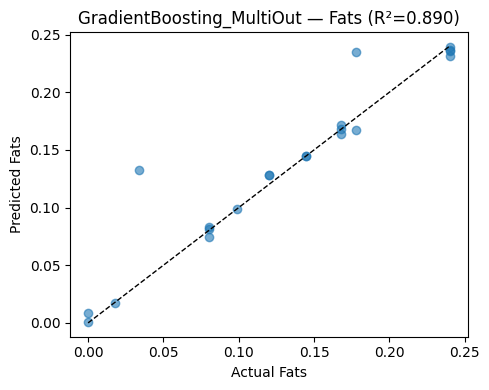

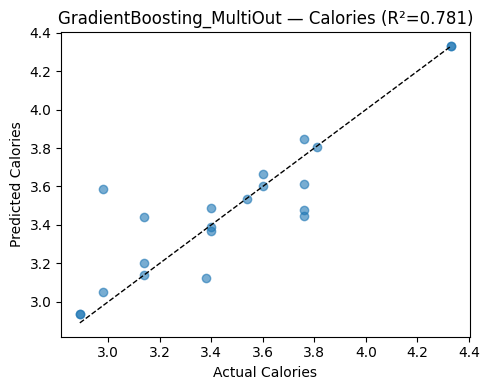

In [11]:
# Colab cell 8/12 — plots for best model
best_model_name = summary_df.iloc[0]['model']
print("Best model:", best_model_name)
best_pipe = fitted_models[best_model_name]
y_pred_best = best_pipe.predict(X_test)

for i, t in enumerate(y_cols):
    plt.figure(figsize=(5,4))
    plt.scatter(y_test[:,i], y_pred_best[:,i], alpha=0.6)
    m = np.min([y_test[:,i].min(), y_pred_best[:,i].min()])
    M = np.max([y_test[:,i].max(), y_pred_best[:,i].max()])
    plt.plot([m,M],[m,M], '--', linewidth=1, color='k')
    plt.xlabel("Actual " + t)
    plt.ylabel("Predicted " + t)
    plt.title(f"{best_model_name} — {t} (R²={r2_score(y_test[:,i], y_pred_best[:,i]):.3f})")
    plt.tight_layout()
    plt.show()


,importance
F6,0.3436
F5,0.1346
F2,0.1160
F7,0.1062
F8,0.0898
F4,0.0871
F3,0.0609
F1,0.0384
NIR,0.0233


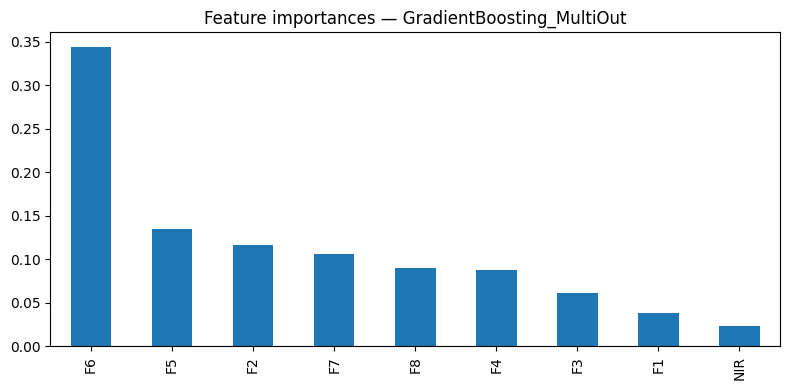

In [12]:
# Colab cell 9/12 — feature importances (averaged if multi-output wrappers)
def get_feature_importances(pipe, feature_names):
    reg = pipe.named_steps['reg']
    # If MultiOutputRegressor: average feature_importances_ of each sub-estimator
    if isinstance(reg, MultiOutputRegressor):
        importances = np.mean([est.feature_importances_ for est in reg.estimators_], axis=0)
    else:
        try:
            importances = reg.feature_importances_
        except Exception:
            return None
    return pd.Series(importances, index=feature_names).sort_values(ascending=False)

fi = get_feature_importances(fitted_models[best_model_name], X_cols)
if fi is not None:
    display(fi.to_frame("importance").round(4))
    fi.plot(kind='bar', figsize=(8,4), title=f"Feature importances — {best_model_name}")
    plt.tight_layout()
    plt.show()
else:
    print("No feature importances available for model:", best_model_name)


In [13]:
# Colab cell 10/12 — quick CV using cross_validate (scoring average across outputs)
from sklearn.metrics import make_scorer

def neg_rmse_scorer(y_true, y_pred):
    # returns negative RMSE averaged across outputs
    return -np.sqrt(mean_squared_error(y_true, y_pred, multioutput='uniform_average'))

scorer = make_scorer(neg_rmse_scorer)
cv_results = {}
for name, pipe in models.items():
    print("CV:", name)
    res = cross_validate(pipe, X, y, scoring=scorer, cv=5, n_jobs=-1, return_train_score=False)
    mean_neg_rmse = res['test_score'].mean()
    cv_results[name] = {"mean_rmse": -mean_neg_rmse, "std_rmse": res['test_score'].std()}
pd.DataFrame(cv_results).T.sort_values("mean_rmse")


CV: LinearRegression
CV: RandomForest
CV: GradientBoosting_MultiOut
CV: XGBoost_MultiOut
CV: MLP


,mean_rmse,std_rmse
RandomForest,0.269535,0.053562
GradientBoosting_MultiOut,0.274163,0.053754
XGBoost_MultiOut,0.289872,0.052323
LinearRegression,0.291356,0.122694
MLP,0.696291,0.984743


In [14]:
# Colab cell 11/12 — randomized search for RandomForest wrapped to multioutput via estimator__
from sklearn.model_selection import RandomizedSearchCV
base_rf = RandomForestRegressor(random_state=RND, n_jobs=-1)
multi_rf = MultiOutputRegressor(base_rf)

param_distributions = {
    'estimator__n_estimators': [50, 100, 200],
    'estimator__max_depth': [None, 10, 20, 30],
    'estimator__max_features': ['auto', 'sqrt', 0.5]
}

rs = RandomizedSearchCV(multi_rf, param_distributions, n_iter=6, scoring='neg_root_mean_squared_error',
                        cv=3, random_state=RND, n_jobs=-1, verbose=1)
rs.fit(X_train, y_train)
print("Best params:", rs.best_params_)
print("Best CV score (neg RMSE):", rs.best_score_)

# Evaluate best on test
best_rf = rs.best_estimator_
y_pred_rf = best_rf.predict(X_test)
display(evaluate_multioutput(y_test, y_pred_rf, y_cols))


Fitting 3 folds for each of 6 candidates, totalling 18 fits
Best params: {'estimator__n_estimators': 100, 'estimator__max_features': 0.5, 'estimator__max_depth': 10}
Best CV score (neg RMSE): -0.07600172870702214


,target,rmse,mae,r2
0,Proteins,0.020327,0.013301,0.907685
1,Carbohydrates,0.033086,0.024426,0.947630
2,Fats,0.023455,0.016358,0.905249
3,Calories,0.216751,0.148267,0.715818


In [15]:
# Colab cell 12/12 — save best model + example of predicting new samples
# Choose which model to save (best by earlier summary)
to_save_name = best_model_name  # or 'RandomForest' or 'XGBoost_MultiOut' etc.
model_obj = fitted_models[to_save_name]

# Save pipeline
save_path = f"/content/drive/MyDrive/Nutrition_prediction/{to_save_name}_pipeline.joblib"
joblib.dump(model_obj, save_path)
print("Saved pipeline to:", save_path)

# Example: predict on new data (supply as DataFrame with X_cols)
example_df = pd.DataFrame([
    {c: df_model[c].mean() for c in X_cols},    # a "mean" sample
    {c: df_model[c].median() for c in X_cols}   # a "median" sample
])
print("Example input shape:", example_df.shape)
preds = model_obj.predict(example_df.values)
pred_df = pd.DataFrame(preds, columns=y_cols)
display(pred_df)


Saved pipeline to: /content/drive/MyDrive/Nutrition_prediction/GradientBoosting_MultiOut_pipeline.joblib
Example input shape: (2, 9)


,Proteins,Carbohydrates,Fats,Calories
0,0.032864,0.646543,0.069620,3.378204
1,0.118956,0.495636,0.090877,3.022282


In [21]:
# Cell A — Load sheet and prepare/train or load an existing pipeline
import os
import joblib
import pandas as pd
import numpy as np

# Path to Excel file - set fname if not already defined in your session
# If you used files.upload() earlier, fname should be present; otherwise set the path:
fname = '/content/drive/MyDrive/Nutrition_prediction/Nutrition Ai Dataset.xlsx'
try:
    fname
except NameError:
    # fallback: automatically pick first .xlsx in working dir
    import glob
    candidates = glob.glob("/content/*.xlsx") + glob.glob("*.xlsx")
    if candidates:
        fname = candidates[0]
        print("Auto-selected Excel file:", fname)
    else:
        raise RuntimeError("No Excel file found in the environment. Upload your .xlsx and set `fname`.")

# Read dataframe
df_sheet = pd.read_excel(fname)
df_sheet.columns = [str(c).strip() for c in df_sheet.columns]

# Define expected inputs and targets (adjust names here if needed)
input_cols = [f"F{i}" for i in range(1,9)] + ["NIR"]
target_cols = ["Proteins", "Carbohydrates", "Fats", "Calories"]

# Confirm columns available
available_inputs = [c for c in input_cols if c in df_sheet.columns]
available_targets = [c for c in target_cols if c in df_sheet.columns]
print("Available inputs:", available_inputs)
print("Available targets:", available_targets)

if len(available_inputs) == 0 or len(available_targets) == 0:
    raise RuntimeError("No input or target columns found in sheet. Check column names.")

# Path to saved pipeline
PIPE_PATH = "best_pipeline.joblib"

# If pipeline exists, load it. Otherwise train a quick baseline pipeline (RandomForest) and save it.
if os.path.exists(PIPE_PATH):
    print("Found saved pipeline at", PIPE_PATH, "- loading it.")
    pipeline = joblib.load(PIPE_PATH)
else:
    print("No saved pipeline found at", PIPE_PATH, "- training a quick RandomForest pipeline on the sheet data.")
    # Prepare data (drop rows with missing inputs/targets)
    df_model = df_sheet[available_inputs + available_targets].dropna().reset_index(drop=True)
    X = df_model[available_inputs].values
    y = df_model[available_targets].values
    # quick train/test split (not strictly needed for saving, but we keep a validation)
    from sklearn.model_selection import train_test_split
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)
    # Build pipeline
    from sklearn.pipeline import Pipeline
    from sklearn.preprocessing import StandardScaler
    from sklearn.multioutput import MultiOutputRegressor
    from sklearn.ensemble import RandomForestRegressor

    pipeline = Pipeline([
        ("scaler", StandardScaler()),
        ("reg", MultiOutputRegressor(RandomForestRegressor(n_estimators=200, random_state=42, n_jobs=-1)))
    ])

    pipeline.fit(X_train, y_train)
    # quick validation metrics
    y_val_pred = pipeline.predict(X_val)
    from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
    def print_val_metrics(y_true, y_pred, targets):
        for i, t in enumerate(targets):
            mse = mean_squared_error(y_true[:,i], y_pred[:,i])
            rmse = np.sqrt(mse)
            mae = mean_absolute_error(y_true[:,i], y_pred[:,i])
            r2 = r2_score(y_true[:,i], y_pred[:,i])
            print(f"{t}: RMSE={rmse:.4f}, MAE={mae:.4f}, R2={r2:.4f}")
    print("Validation metrics on held-out 20%:")
    print_val_metrics(y_val, y_val_pred, available_targets)

    # Save pipeline
    joblib.dump(pipeline, PIPE_PATH)
    print("Saved pipeline to", PIPE_PATH)

# pipeline is now ready


Available inputs: ['F1', 'F2', 'F3', 'F4', 'F5', 'F6', 'F7', 'F8', 'NIR']
Available targets: ['Proteins', 'Carbohydrates', 'Fats', 'Calories']
No saved pipeline found at best_pipeline.joblib - training a quick RandomForest pipeline on the sheet data.
Validation metrics on held-out 20%:
Proteins: RMSE=0.0223, MAE=0.0139, R2=0.8887
Carbohydrates: RMSE=0.0293, MAE=0.0209, R2=0.9589
Fats: RMSE=0.0179, MAE=0.0118, R2=0.9447
Calories: RMSE=0.2026, MAE=0.1344, R2=0.7518
Saved pipeline to best_pipeline.joblib


Inference

In [22]:
# ---- Inference Cell ----
import pandas as pd
import joblib
import numpy as np

# 1️⃣  Define your sample input (from your message)
sample_data = {
    'F1': 2.0,
    'F2': 7.0,
    'F3': 8.0,
    'F4': 10.0,
    'F5': 21.0,
    'F6': 28.0,
    'F7': 29.0,
    'F8': 20.0,
    'NIR': 6.0
}

# 2️⃣  Convert to DataFrame (model expects a 2D array)
sample_df = pd.DataFrame([sample_data])
print("Input sample:")
display(sample_df)

# 3️⃣  Load your trained pipeline (update path if needed)

PIPE_PATH = "best_pipeline.joblib"  # change if your model was saved with another name
pipeline = joblib.load(PIPE_PATH)

# 4️⃣  Make prediction
pred = pipeline.predict(sample_df.values)

# 5️⃣  Define output target names (based on your training)
target_cols = ["Proteins", "Carbohydrates", "Fats", "Calories"]

# 6️⃣  Show predicted results neatly
pred_df = pd.DataFrame(pred, columns=target_cols)
print("Predicted nutritional composition:")
display(pred_df.round(4))


Input sample:


,F1,F2,F3,F4,F5,F6,F7,F8,NIR
0,2.0,7.0,8.0,10.0,21.0,28.0,29.0,20.0,6.0


Predicted nutritional composition:


,Proteins,Carbohydrates,Fats,Calories
0,0.0394,0.8186,0.0053,3.636
